In [1]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
from itertools import islice
import numpy as np
from skimage.external import tifffile
from skimage.external.tifffile import imread
import matplotlib.pyplot as plt
import ipywidgets as widgets
import random
from scipy.ndimage.morphology import binary_erosion as br
from skimage import morphology as skmor
from scipy import ndimage
from PIL import Image, ImageDraw
import numpy.ma as ma
from skimage.measure import label, regionprops

from sklearn.cluster import KMeans


In [2]:
import seaborn as sns

# Contents
* [Data Loading](#data)
* [Sampling](#samples)
* [Data Analysis](#EDA)
    1. [first image](#1st)

## Pixel Distribution of HP1 (HP1B) and DAPI signal <a name="data"></a>
- Select random 10 cells from the chosen dataset
- calculate HP1 (HP1B) signal and DAPI signal for each pixel of the image
- plot HP1 signal vs DAPI signal for each cell 
- look for any pattern noticed - ex) normal linear relationship, grouping in the plots, etc

In [3]:
bigDir=r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading'

In [4]:
newfile=f'{bigDir}\\new dataset\signals_new_v5.csv'

In [5]:
newdata=pd.read_csv(newfile)

In [6]:
newdata=newdata.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [7]:
newdata.head()

,file,original cell name,movie,last frame movie position x,last frame movie position y,ab1 (MCM),ab1 ch,ab2 (heterochromatin),ab2 ch,DAPI ch,...,mol_age_mod,nuc_hp1b_total,inner_hp1b_total,outer_hp1b_total,nuc_hp1b_het,inner_hp1b_het,outer_hp1b_het,nuc_hp1b_eu,inner_hp1b_eu,outer_hp1b_eu
0,20191203_cell-00.czi,20191125-01-17,191125pcnat_dhbr_cdc6vxy01,678.301,200.931,MCM3,1,HP1beta,2,3,...,0.444,1.415176e+09,425500564.0,9.896759e+08,550518042.0,321679433.0,228838609.0,8.646584e+08,103821131.0,7.608373e+08
1,20191203_cell-01.czi,20191125-01-20,191125pcnat_dhbr_cdc6vxy01,1552.152,240.479,MCM3,1,HP1beta,2,3,...,1.373,2.175016e+09,804184935.0,1.370831e+09,896267478.0,567124747.0,329142731.0,1.278748e+09,237060188.0,1.041688e+09
2,20191203_cell-02.czi,20191125-01-23,191125pcnat_dhbr_cdc6vxy01,1131.436,318.530,MCM3,1,HP1beta,2,3,...,1.371,1.933001e+09,666820604.0,1.266180e+09,732487366.0,444813519.0,287673847.0,1.200514e+09,222007085.0,9.785064e+08
3,20191203_cell-03.czi,20191125-01-25,191125pcnat_dhbr_cdc6vxy01,1650.585,324.968,MCM3,1,HP1beta,2,3,...,0.208,1.062142e+09,233589820.0,8.285525e+08,403943621.0,187675893.0,216267728.0,6.581987e+08,45913927.0,6.122848e+08
4,20191203_cell-04.czi,20191125-01-32,191125pcnat_dhbr_cdc6vxy01,1466.687,426.815,MCM3,1,HP1beta,2,3,...,0.345,1.717888e+09,546330833.0,1.171557e+09,697150763.0,424718652.0,272432111.0,1.020738e+09,121612181.0,8.991254e+08


In [8]:
file=f'{bigDir}\\20200217_geminin\\200217_cellinfo_v7.csv'

In [9]:
geminin=pd.read_csv(file)

In [10]:
geminin=geminin.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [11]:
geminin.head()

,file,original cell name,movie,x,y,ab1 (MCM),ab1 ch,ab2 (heterochromatin),ab2 ch,DAPI ch,...,outer_DAPI_total,nuc_DAPI_het,inner_DAPI_het,outer_DAPI_het,nuc_DAPI_eu,inner_DAPI_eu,outer_DAPI_eu,day,physical_age,mol_age_mod
0,20200217_cell_00.ciz,2020024-19-21-63X.czi,20200217pinducer gemininxy19,1312.741,235.893,MCM3,1,HP1,2,3,...,1.425797e+09,7.791948e+08,4.701984e+08,308996412.0,1.214105e+09,97303963.0,1.116801e+09,d20200217,8.833333,0.948
1,20200217_cell_01.ciz,2020024-19-27-63X.czi,20200217pinducer gemininxy19,1323.444,397.761,MCM3,1,HP1,2,3,...,1.407304e+09,7.501514e+08,4.772260e+08,272925417.0,1.302409e+09,168031096.0,1.134378e+09,d20200217,5.666667,0.465
2,20200217_cell_02.ciz,2020024-19-39-63X.czi,20200217pinducer gemininxy19,1772.297,584.995,MCM3,1,HP1,2,3,...,2.488888e+09,1.402612e+09,1.055936e+09,346675531.0,2.494576e+09,352363680.0,2.142212e+09,d20200217,NaN,2.001
3,20200217_cell_03.ciz,2020024-19-49-63X.czi,20200217pinducer gemininxy19,163.044,727.256,MCM3,1,HP1,2,3,...,1.395355e+09,8.721556e+08,6.594996e+08,212655978.0,1.360779e+09,178079736.0,1.182699e+09,d20200217,7.833333,1.063
4,20200217_cell_04.ciz,2020024-19-51-63X.czi,20200217pinducer gemininxy19,1791.955,755.367,MCM3,1,HP1,2,3,...,1.422570e+09,7.409389e+08,4.345226e+08,306416352.0,1.222306e+09,106151998.0,1.116154e+09,d20200217,5.666667,0.579


## Sampling  <a name="samples"></a>

sample = 10 samples from newdata; this data used ***HP1Beta***<br>
sample_geminin = 10 samples from geminin dataset; this data used ***HP1***

In [12]:
sample=newdata.loc[(newdata.decon==False),:]

In [13]:
sample=sample.loc[(['G1' in x for x in sample.category]), :].sample(n=10, random_state=107)

In [14]:
sample

,file,original cell name,movie,last frame movie position x,last frame movie position y,ab1 (MCM),ab1 ch,ab2 (heterochromatin),ab2 ch,DAPI ch,...,mol_age_mod,nuc_hp1b_total,inner_hp1b_total,outer_hp1b_total,nuc_hp1b_het,inner_hp1b_het,outer_hp1b_het,nuc_hp1b_eu,inner_hp1b_eu,outer_hp1b_eu
102,20191203_cell-130.czi,20191125-08-101,191125pcnat_dhbr_cdc6vxy08,1237.094,1258.126,MCM3,1,HP1beta,2,3,...,0.721,1.285848e+09,390107622.0,8.957405e+08,487715875.0,290984487.0,196731388.0,798132293.0,99123135.0,699009158.0
3,20191203_cell-03.czi,20191125-01-25,191125pcnat_dhbr_cdc6vxy01,1650.585,324.968,MCM3,1,HP1beta,2,3,...,0.208,1.062142e+09,233589820.0,8.285525e+08,403943621.0,187675893.0,216267728.0,658198734.0,45913927.0,612284807.0
108,20191203_cell-137.czi,20191125-11-82,191125pcnat_dhbr_cdc6vxy11,916.914,921.865,MCM3,1,HP1beta,2,3,...,0.701,1.340251e+09,442330664.0,8.979200e+08,509021593.0,325983023.0,183038570.0,831229094.0,116347641.0,714881453.0
58,20191203_cell-78.czi,20191125-05-44,191125pcnat_dhbr_cdc6vxy05,947.721,652.410,MCM3,1,HP1beta,2,3,...,0.422,1.216596e+09,363577325.0,8.530182e+08,456375018.0,263518999.0,192856019.0,760220527.0,100058326.0,660162201.0
49,20191203_cell-64.czi,20191125-10-142,191125pcnat_dhbr_cdc6vxy10,520.447,1594.921,MCM3,1,HP1beta,2,3,...,1.009,1.448302e+09,408907699.0,1.039394e+09,561312449.0,288467325.0,272845124.0,886989714.0,120440374.0,766549340.0
67,20191203_cell-87.czi,20191125-05-88,191125pcnat_dhbr_cdc6vxy05,301.901,1450.886,MCM3,1,HP1beta,2,3,...,0.208,1.173185e+09,255938367.0,9.172463e+08,438885958.0,196474325.0,242411633.0,734298719.0,59464042.0,674834677.0
81,20191203_cell-103.czi,20191125-07-55,191125pcnat_dhbr_cdc6vxy07,598.905,812.930,MCM3,1,HP1beta,2,3,...,0.462,1.039684e+09,208705380.0,8.309790e+08,384549104.0,167188893.0,217360211.0,655135258.0,41516487.0,613618771.0
60,20191203_cell-80.czi,20191125-05-56,191125pcnat_dhbr_cdc6vxy05,467.635,889.574,MCM3,1,HP1beta,2,3,...,0.674,1.373778e+09,453944387.0,9.198338e+08,519606383.0,326294309.0,193312074.0,854171789.0,127650078.0,726521711.0
95,20191203_cell-123.czi,20191125-07-125,191125pcnat_dhbr_cdc6vxy07,1258.357,1764.788,MCM3,1,HP1beta,2,3,...,0.649,1.204104e+09,355183847.0,8.489197e+08,434319799.0,257178787.0,177141012.0,769783719.0,98005060.0,671778659.0
5,20191203_cell-05.czi,20191125-01-36,191125pcnat_dhbr_cdc6vxy01,1705.099,468.246,MCM3,1,HP1beta,2,3,...,0.632,1.615431e+09,530009467.0,1.085421e+09,699466569.0,454510713.0,244955856.0,915964380.0,75498754.0,840465626.0


In [15]:
sample_geminin=geminin.loc[(geminin.group=='CTL'),:]

sample_geminin=sample_geminin.loc[(['G1' in x for x in sample_geminin.category]), :].sample(n=10, random_state=107)

sample_geminin

,file,original cell name,movie,x,y,ab1 (MCM),ab1 ch,ab2 (heterochromatin),ab2 ch,DAPI ch,...,outer_DAPI_total,nuc_DAPI_het,inner_DAPI_het,outer_DAPI_het,nuc_DAPI_eu,inner_DAPI_eu,outer_DAPI_eu,day,physical_age,mol_age_mod
55,20200217_cell_56.ciz,2020024-21-69-63X.czi,20200217pinducer gemininxy21,1679.774,853.901,MCM3,1,HP1,2,3,...,1.831348e+09,735528431.0,342193413.0,393335018.0,1.575331e+09,137317117.0,1.438013e+09,d20200217,7.166667,0.913
52,20200217_cell_53.ciz,2020024-21-56-63X.czi,20200217pinducer gemininxy21,491.477,686.327,MCM3,1,HP1,2,3,...,1.325073e+09,989964835.0,799149458.0,190815377.0,1.367327e+09,233069560.0,1.134257e+09,d20200217,2.833333,0.312
41,20200217_cell_41.ciz,2020024-20-129-63X.czi,20200217pinducer gemininxy20,956.116,1670.198,MCM3,1,HP1,2,3,...,1.430629e+09,825203997.0,592632646.0,232571351.0,1.346245e+09,148187340.0,1.198057e+09,d20200217,7.333333,0.980
33,20200217_cell_33.ciz,2020024-20-72-63X.czi,20200217pinducer gemininxy20,693.390,929.068,MCM3,1,HP1,2,3,...,1.555030e+09,993091013.0,752317813.0,240773200.0,1.507446e+09,193189960.0,1.314256e+09,d20200217,9.666667,1.098
0,20200217_cell_00.ciz,2020024-19-21-63X.czi,20200217pinducer gemininxy19,1312.741,235.893,MCM3,1,HP1,2,3,...,1.425797e+09,779194775.0,470198363.0,308996412.0,1.214105e+09,97303963.0,1.116801e+09,d20200217,8.833333,0.948
39,20200217_cell_39.ciz,2020024-20-111-63X.czi,20200217pinducer gemininxy20,1306.021,1454.848,MCM3,1,HP1,2,3,...,1.181791e+09,760838823.0,603861106.0,156977717.0,1.152483e+09,127669744.0,1.024813e+09,d20200217,3.166667,0.282
59,20200217_cell_60.ciz,2020024-21-91-63X.czi,20200217pinducer gemininxy21,1292.148,1095.184,MCM3,1,HP1,2,3,...,1.531307e+09,911067747.0,625595380.0,285472367.0,1.462186e+09,216351806.0,1.245835e+09,d20200217,5.000000,0.222
58,20200217_cell_59.ciz,2020024-21-84-63X.czi,20200217pinducer gemininxy21,1388.189,1001.713,MCM3,1,HP1,2,3,...,1.460786e+09,894902823.0,644872562.0,250030261.0,1.406651e+09,195894622.0,1.210756e+09,d20200217,7.333333,0.844
9,20200217_cell_09.ciz,2020024-19-79-63X.czi,20200217pinducer gemininxy19,398.674,1037.764,MCM3,1,HP1,2,3,...,1.525443e+09,890740746.0,604191565.0,286549181.0,1.412280e+09,173386032.0,1.238894e+09,d20200217,6.833333,0.726
12,20200217_cell_12.ciz,2020024-19-93-63X.czi,20200217pinducer gemininxy19,1841.328,1182.675,MCM3,1,HP1,2,3,...,1.530362e+09,839243088.0,548132923.0,291110165.0,1.350745e+09,111493747.0,1.239252e+09,d20200217,2.000000,0.429


## Data Analysis <a name="EDA"></a>

# first image <a name="1st"></a>
* [Density plots](#1Density)
* [Sample plots](#1Sample)
* [Comparison](#1Comparison)

In [16]:
i=0

In [69]:
i=0
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1b=cell[:,1,:,:] 
## masking the image
hp1b[~nuc]=0
hp1b=hp1b.astype(np.ndarray)

# DAPI channel
dapiB=cell[:,2,:,:]
dapiB[~nuc]=0


## HP1, geminin dataset
i=0
mycell=sample_geminin.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


20191203_cell-130.czi
shape of the cell image:  (29, 3, 380, 380)
shape of nucleus mask:  (29, 380, 380)
20200217_cell_56.ciz
shape of the cell image:  (22, 3, 380, 380)
shape of nucleus mask:  (22, 380, 380)


#### making hp1beta and dapi signals as 1d (reducing the factor of slices or any axis limitations)

In [18]:
hp1b.max()

65535

In [19]:
dapiB.max()

41919

In [20]:
hp1b_test=hp1b.ravel()
hp1b_test.shape

(4187600,)

In [21]:
dapiB_test=dapiB.ravel()
dapiB_test.shape

(4187600,)

#### making hp1 and dapi signals as 1d (reducing the factor of slices or any axis limitations)

In [37]:
hp1.max()

47432

In [38]:
dapi.max()

31365

In [39]:
hp1_test=hp1.ravel()
hp1_test.shape

(3176800,)

In [40]:
dapi_test=dapi.ravel()
dapi_test.shape

(3176800,)

## density plot <a name="1Density"></a>

### HP1Beta

<IPython.core.display.Javascript object>


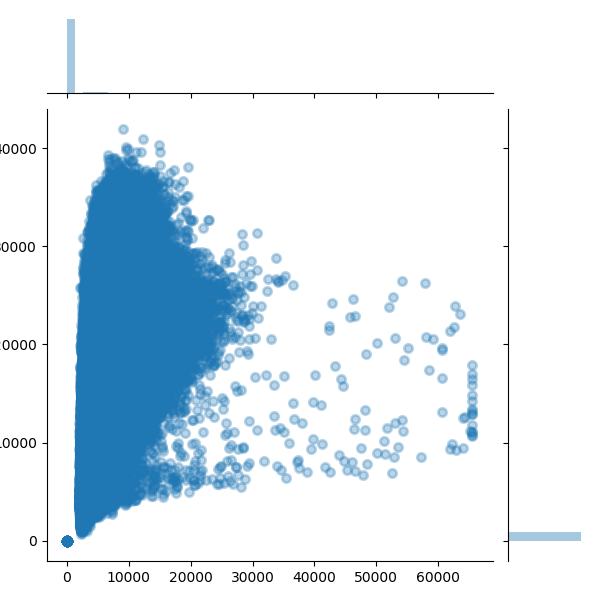

In [22]:
%matplotlib notebook
sns.jointplot(x=hp1b_test,y=dapiB_test,kind='scatter', linewidth=2,alpha=0.3)

### HP1

<IPython.core.display.Javascript object>


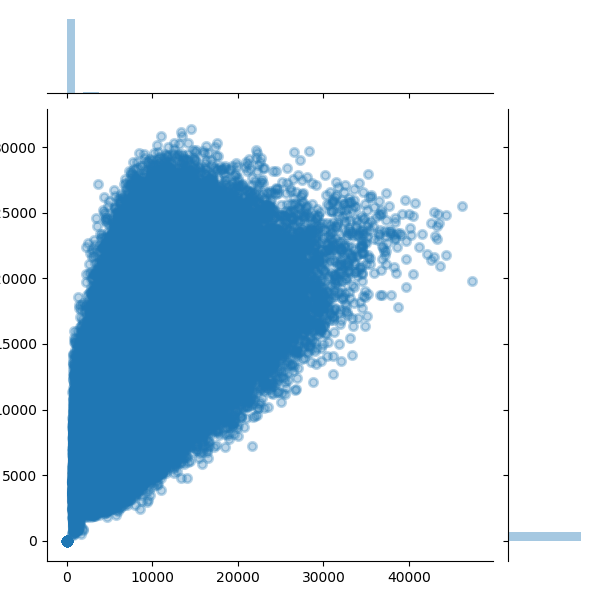

In [41]:
%matplotlib notebook
sns.jointplot(x=hp1_test,y=dapi_test,kind='scatter', linewidth=2,alpha=0.3)

## remove some data points

- remove pixel values of saturated pixels and 0 pixels, which are most likly the background pixels

### HP1Beta

In [23]:
hp1b_test[hp1b_test==0].shape

(3952366,)

In [24]:
hp1b_test_non_zero=hp1b_test[~(hp1b_test==0)]

In [25]:
hp1b_test_non_zero.shape

(235234,)

In [26]:
dapiB_test[dapiB_test==0].shape

(3952366,)

In [27]:
dapiB_test_non_zero=dapiB_test[~(dapiB_test==0)]

In [28]:
dapiB_test_non_zero.shape

(235234,)

### HP1

In [42]:
hp1_test[hp1_test==0].shape

(2968188,)

In [43]:
hp1_test_non_zero=hp1_test[~(hp1_test==0)]

In [44]:
hp1_test_non_zero.shape

(208612,)

In [45]:
dapi_test[dapi_test==0].shape

(2968188,)

In [46]:
dapi_test_non_zero=dapi_test[~(dapi_test==0)]

In [47]:
dapi_test_non_zero.shape

(208612,)

## Sample plots <a name="1Sample"></a>

### samples from non-zero array

In [29]:
idx = np.random.choice(np.arange(len(hp1b_test_non_zero)), 1000, replace=False)
hp1b_test_sample = hp1b_test_non_zero[idx]
dapiB_test_sample = dapiB_test_non_zero[idx]

In [30]:
hp1b_test_sample.shape

(1000,)

<IPython.core.display.Javascript object>


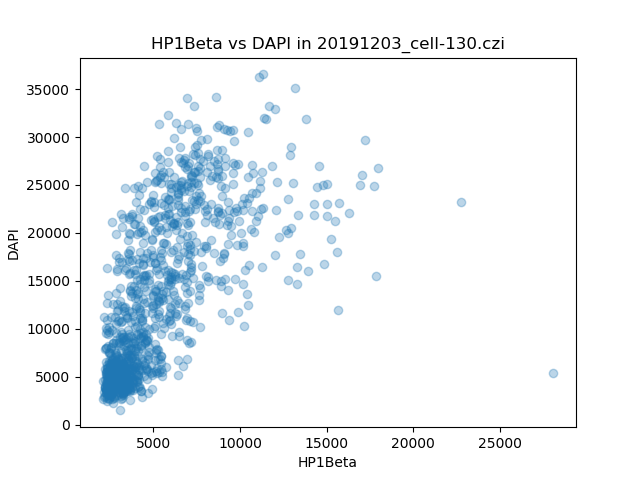

Text(0.5, 1.0, 'HP1Beta vs DAPI in 20191203_cell-130.czi')

In [31]:
%matplotlib notebook
plt.scatter(x=hp1b_test_sample, y= dapiB_test_sample, alpha=0.3)
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1Beta vs DAPI in {mycell.file}')

In [33]:
hp1b_test_non_zero.max()

65535

In [34]:
hp1b_test_non_zero[~(hp1b_test_non_zero==hp1b_test_non_zero.max())].max()

65166

### samples from non-zero array

In [48]:
idx = np.random.choice(np.arange(len(hp1_test_non_zero)), 1000, replace=False)
hp1_test_sample = hp1_test_non_zero[idx]
dapi_test_sample = dapi_test_non_zero[idx]

In [49]:
hp1_test_sample.shape

(1000,)

<IPython.core.display.Javascript object>


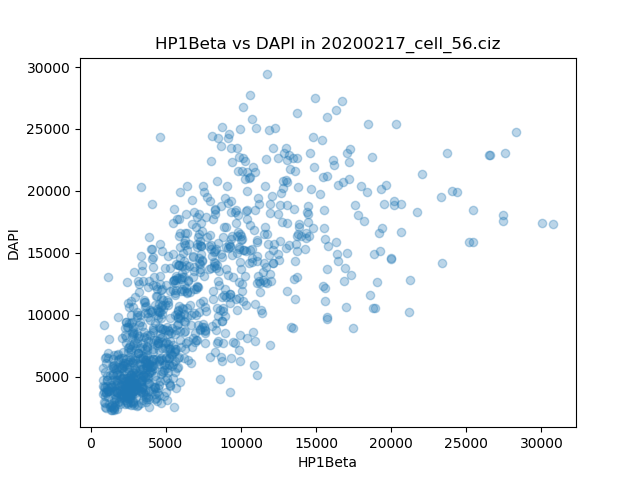

Text(0.5, 1.0, 'HP1Beta vs DAPI in 20200217_cell_56.ciz')

In [50]:
%matplotlib notebook
plt.scatter(x=hp1_test_sample, y= dapi_test_sample, alpha=0.3)
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1Beta vs DAPI in {mycell.file}')

## compare HP1 and HP1B <a name="1Comparison"></a>

<IPython.core.display.Javascript object>


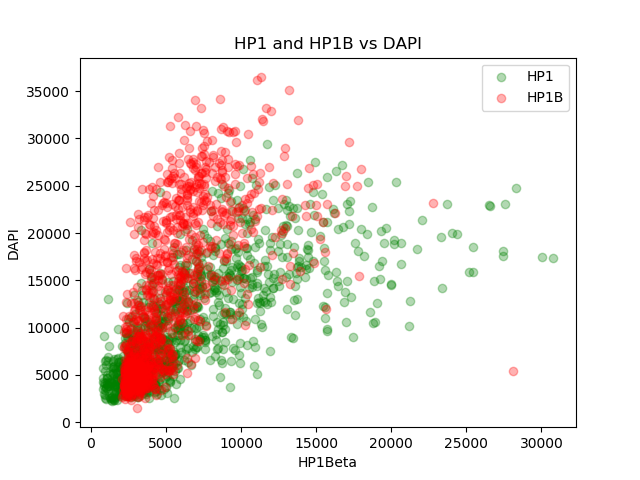

Text(0.5, 1.0, 'HP1 and HP1B vs DAPI')

In [51]:
%matplotlib notebook
plt.scatter(x=hp1_test_sample, y= dapi_test_sample, alpha=0.3, color='green', label='HP1')
plt.scatter(x=hp1b_test_sample, y= dapiB_test_sample, alpha=0.3, color='red', label='HP1B')

plt.legend()
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1 and HP1B vs DAPI')

# second image <a name="2nd"></a>
* [Density plots](#2Density)
* [Sample plots](#2Sample)
* [Comparison](#2Comparison)

In [17]:
i+=1

In [52]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print("HP1B")
print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1b=cell[:,1,:,:] 
## masking the image
hp1b[~nuc]=0
hp1b=hp1b.astype(np.ndarray)

# DAPI channel
dapiB=cell[:,2,:,:]
dapiB[~nuc]=0


mycellGeminin=sample_geminin.iloc[i]
%matplotlib notebook
cell=imread(mycellGeminin.path)

nucPath=(mycellGeminin.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print("HP1")
print(mycellGeminin.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


HP1B
20191203_cell-03.czi
shape of the cell image:  (37, 3, 380, 380)
shape of nucleus mask:  (37, 380, 380)
HP1
20200217_cell_53.ciz
shape of the cell image:  (24, 3, 380, 380)
shape of nucleus mask:  (24, 380, 380)


In [53]:
hp1b_test=hp1b.ravel()
dapiB_test=dapiB.ravel()

In [54]:
hp1_test=hp1.ravel()
dapi_test=dapi.ravel()

## Density plot <a name="2Density"></a>

### HP1Beta

<IPython.core.display.Javascript object>


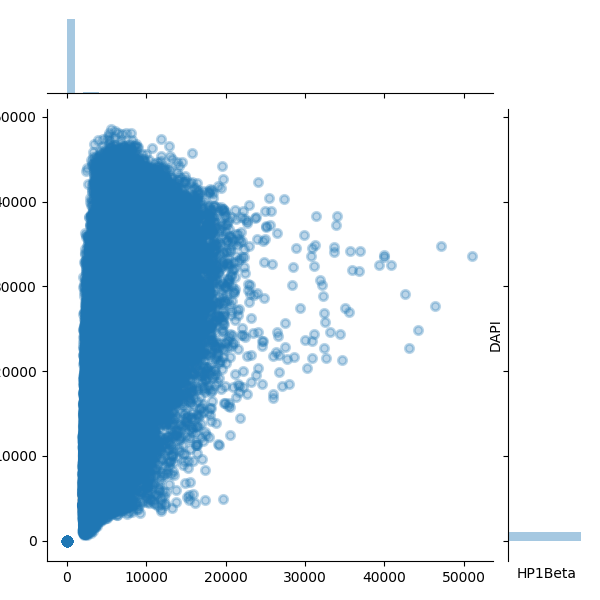

Text(468.01587301587307, 0.5, 'DAPI')

In [55]:
%matplotlib notebook
sns.jointplot(x=hp1b_test,y=dapiB_test,kind='scatter', linewidth=2,alpha=0.3)
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')

### HP1

<IPython.core.display.Javascript object>


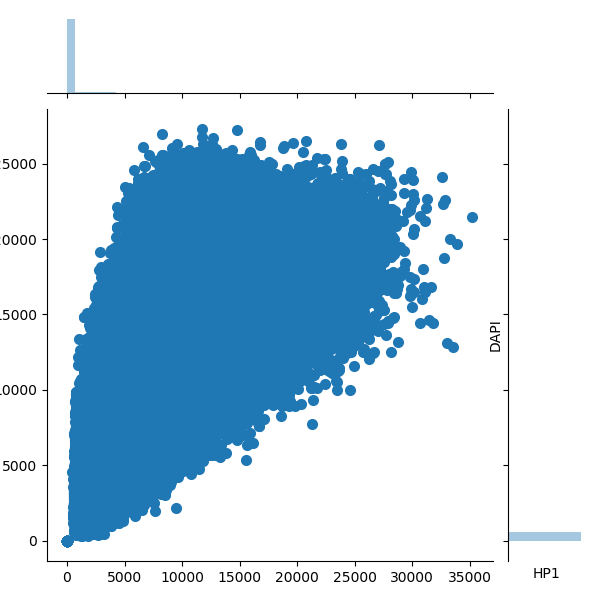

Text(468.01587301587307, 0.5, 'DAPI')

In [56]:
%matplotlib notebook
sns.jointplot(x=hp1_test,y=dapi_test,kind='scatter', linewidth=2)
plt.xlabel('HP1')
plt.ylabel('DAPI')

#### remove 0 

In [57]:
hp1_test_non_zero=hp1_test[~(hp1_test==0)]
hp1_test_non_zero.shape

(328497,)

In [58]:
dapi_test_non_zero=dapi_test[~(dapi_test==0)]
dapi_test_non_zero.shape

(328497,)

## Sample plots <a name="2Sample"></a>

In [59]:
idx = np.random.choice(np.arange(len(hp1_test_non_zero)), 1000, replace=False)
hp1_test_sample = hp1_test_non_zero[idx]
dapi_test_sample = dapi_test_non_zero[idx]

In [60]:
hp1_test_sample.shape

(1000,)

<IPython.core.display.Javascript object>


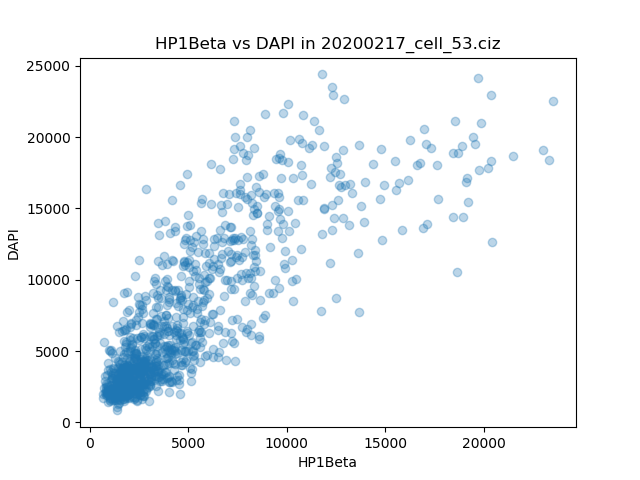

Text(0.5, 1.0, 'HP1Beta vs DAPI in 20200217_cell_53.ciz')

In [61]:
%matplotlib notebook
plt.scatter(x=hp1_test_sample, y= dapi_test_sample, alpha=0.3)
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1Beta vs DAPI in {mycellGeminin.file}')

In [62]:
hp1b_test_non_zero=hp1b_test[~(hp1b_test==0)]
hp1b_test_non_zero.shape

(223869,)

In [63]:
dapiB_test_non_zero=dapiB_test[~(dapiB_test==0)]
dapiB_test_non_zero.shape

(223869,)

In [64]:
idx = np.random.choice(np.arange(len(hp1b_test_non_zero)), 1000, replace=False)
hp1b_test_sample = hp1b_test_non_zero[idx]
dapiB_test_sample = dapiB_test_non_zero[idx]

In [65]:
hp1b_test_sample.shape

(1000,)

<IPython.core.display.Javascript object>


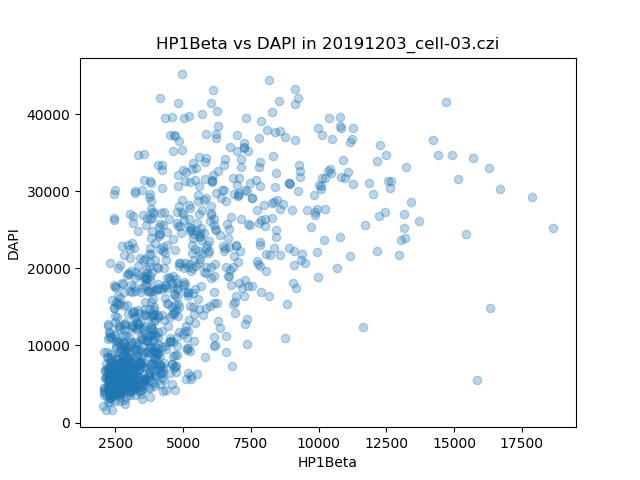

Text(0.5, 1.0, 'HP1Beta vs DAPI in 20191203_cell-03.czi')

In [66]:
%matplotlib notebook
plt.scatter(x=hp1b_test_sample, y= dapiB_test_sample, alpha=0.3)
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1Beta vs DAPI in {mycell.file}')

## Compare HP1 and HP1Beta  <a name="2Comparison"></a>


<IPython.core.display.Javascript object>


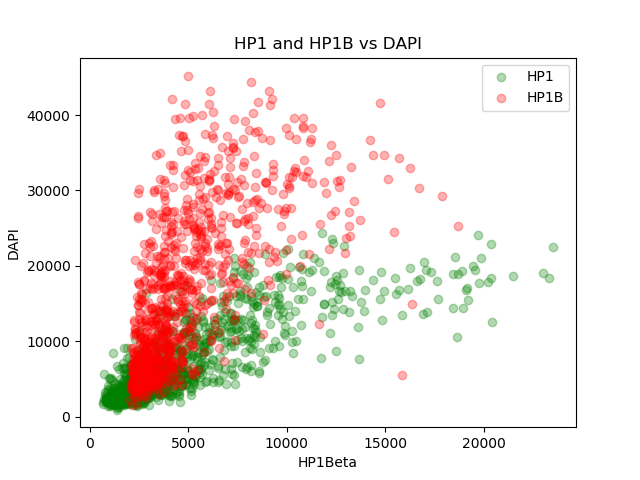

Text(0.5, 1.0, 'HP1 and HP1B vs DAPI')

In [67]:
%matplotlib notebook
plt.scatter(x=hp1_test_sample, y= dapi_test_sample, alpha=0.3, color='green', label='HP1')
plt.scatter(x=hp1b_test_sample, y= dapiB_test_sample, alpha=0.3, color='red', label='HP1B')

plt.legend()
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1 and HP1B vs DAPI')

# third image <a name="3rd"></a>
* [Density plots](#3Density)
* [Sample plots](#3Sample)
* [Comparison](#3Comparison)

In [18]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print("HP1B")
print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1b=cell[:,1,:,:] 
## masking the image
hp1b[~nuc]=0
hp1b=hp1b.astype(np.ndarray)

# DAPI channel
dapiB=cell[:,2,:,:]
dapiB[~nuc]=0


mycellGeminin=sample_geminin.iloc[i]
%matplotlib notebook
cell=imread(mycellGeminin.path)

nucPath=(mycellGeminin.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print("HP1")
print(mycellGeminin.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


HP1B
20191203_cell-137.czi
shape of the cell image:  (31, 3, 380, 380)
shape of nucleus mask:  (31, 380, 380)
HP1
20200217_cell_41.ciz
shape of the cell image:  (24, 3, 380, 380)
shape of nucleus mask:  (24, 380, 380)


In [74]:
hp1b_test=hp1b.ravel()
dapiB_test=dapiB.ravel()

In [75]:
hp1b_test.shape

(4476400,)

In [76]:
dapiB_test.shape

(4476400,)

In [20]:
hp1_test=hp1.ravel()
dapi_test=dapi.ravel()

## Density plot <a name="3Density"></a>

### HP1Beta

In [77]:
hp1b_test_final=hp1b_test[hp1b_test!=hp1b_test.max()]

In [78]:
dapiB_test_final=dapiB_test[hp1b_test!=hp1b_test.max()]

In [79]:
print(hp1b_test_final.shape)
print(dapiB_test_final.shape)

(4476312,)
(4476312,)


<IPython.core.display.Javascript object>


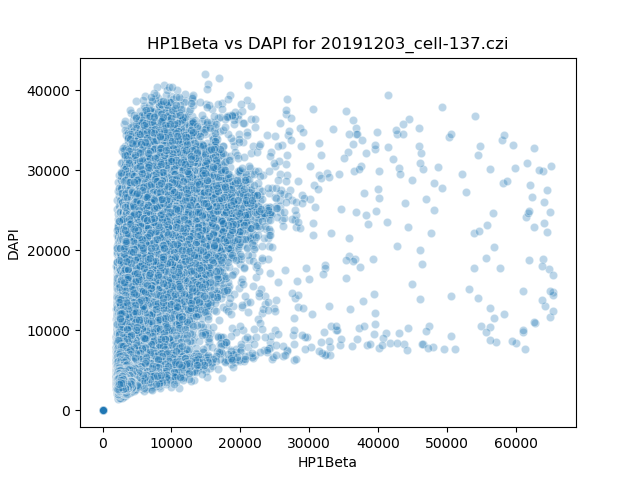

Text(0.5, 1.0, 'HP1Beta vs DAPI for 20191203_cell-137.czi')

In [100]:
%matplotlib notebook
sns.scatterplot(x=hp1b_test_final,y=dapiB_test_final,alpha=0.3)
plt.ticklabel_format(axis='both',style='sci')
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1Beta vs DAPI for {mycell.file}')

### HP1

<IPython.core.display.Javascript object>


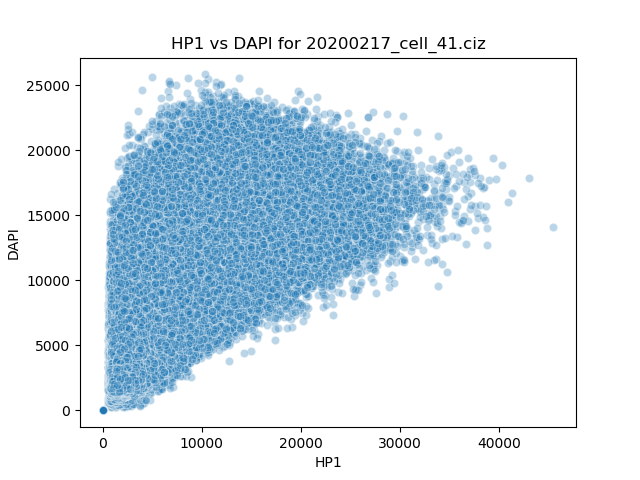

Text(0.5, 1.0, 'HP1 vs DAPI for 20200217_cell_41.ciz')

In [103]:
%matplotlib notebook
sns.scatterplot(x=hp1_test,y=dapi_test,alpha=0.3)
plt.ticklabel_format(axis='both',style='sci')
plt.xlabel('HP1')
plt.ylabel('DAPI')
plt.title(f'HP1 vs DAPI for {mycellGeminin.file}')

<IPython.core.display.Javascript object>


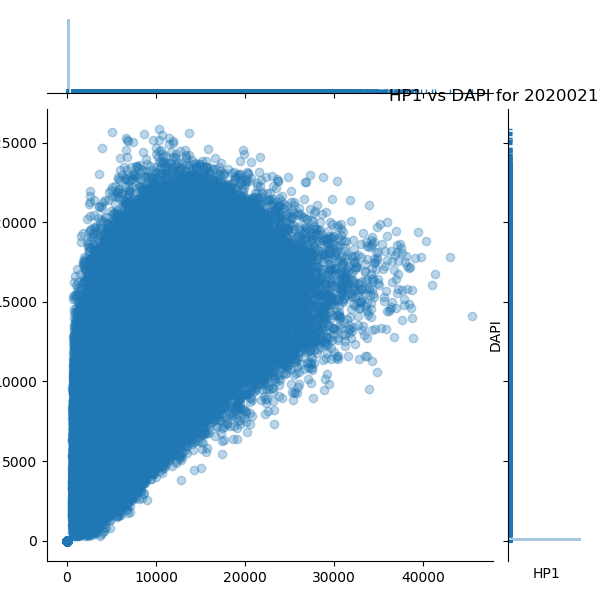

Text(0.5, 1, 'HP1 vs DAPI for 20200217_cell_41.ciz')

In [102]:
%matplotlib notebook
sns.jointplot(x=hp1_test,y=dapi_test,alpha=0.3, marginal_kws=dict(bins=150, rug=True))
plt.ticklabel_format(axis='both',style='sci')
plt.xlabel('HP1')
plt.ylabel('DAPI')
plt.title(f'HP1 vs DAPI for {mycellGeminin.file}')

#### remove 0 

In [83]:
hp1_test_non_zero=hp1_test[~(hp1_test==0)]
hp1_test_non_zero.shape

(291426,)

In [84]:
dapi_test_non_zero=dapi_test[~(dapi_test==0)]
dapi_test_non_zero.shape

(291426,)

## Sample plots <a name="2Sample"></a>

In [85]:
idx = np.random.choice(np.arange(len(hp1_test_non_zero)), 1000, replace=False)
hp1_test_sample = hp1_test_non_zero[idx]
dapi_test_sample = dapi_test_non_zero[idx]

In [86]:
hp1_test_sample.shape

(1000,)

<IPython.core.display.Javascript object>


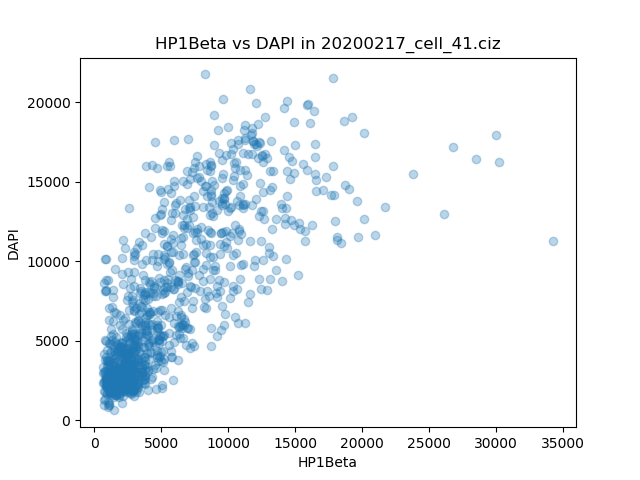

Text(0.5, 1.0, 'HP1Beta vs DAPI in 20200217_cell_41.ciz')

In [87]:
%matplotlib notebook
plt.scatter(x=hp1_test_sample, y= dapi_test_sample, alpha=0.3)
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1Beta vs DAPI in {mycellGeminin.file}')

## remove 0 

In [88]:
hp1b_test_non_zero=hp1b_test_final[~(hp1b_test_final==0)]
hp1b_test_non_zero.shape

(267934,)

In [89]:
dapiB_test_non_zero=dapiB_test_final[~(dapiB_test_final==0)]
dapiB_test_non_zero.shape

(267934,)

In [90]:
idx = np.random.choice(np.arange(len(hp1b_test_non_zero)), 1000, replace=False)
hp1b_test_sample = hp1b_test_non_zero[idx]
dapiB_test_sample = dapiB_test_non_zero[idx]

In [91]:
hp1b_test_sample.shape

(1000,)

<IPython.core.display.Javascript object>


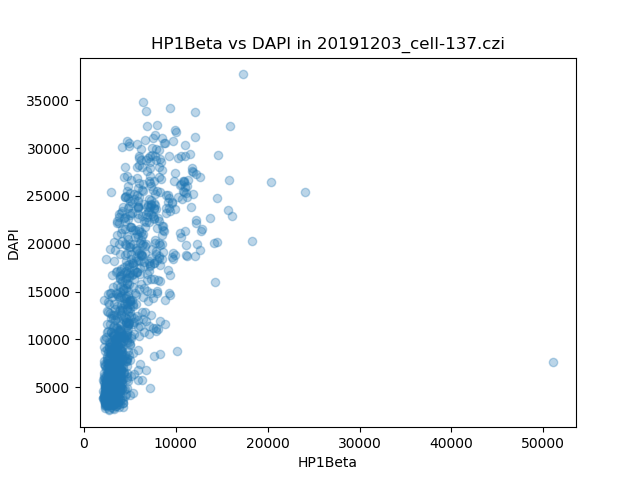

Text(0.5, 1.0, 'HP1Beta vs DAPI in 20191203_cell-137.czi')

In [92]:
%matplotlib notebook
plt.scatter(x=hp1b_test_sample, y= dapiB_test_sample, alpha=0.3)
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1Beta vs DAPI in {mycell.file}')

## Compare HP1 and HP1Beta  <a name="2Comparison"></a>


<IPython.core.display.Javascript object>


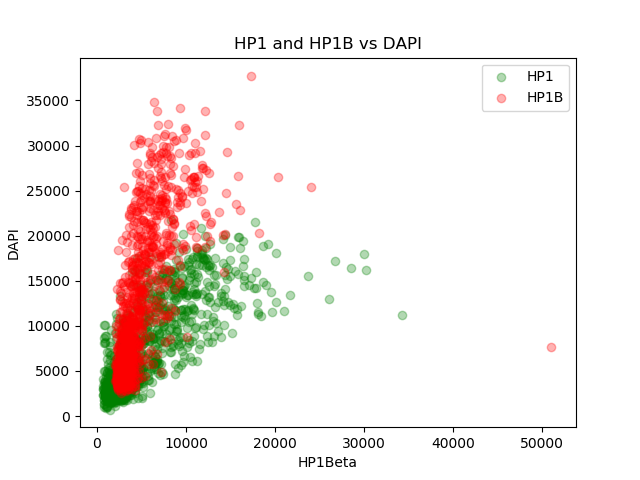

Text(0.5, 1.0, 'HP1 and HP1B vs DAPI')

In [93]:
%matplotlib notebook
plt.scatter(x=hp1_test_sample, y= dapi_test_sample, alpha=0.3, color='green', label='HP1')
plt.scatter(x=hp1b_test_sample, y= dapiB_test_sample, alpha=0.3, color='red', label='HP1B')

plt.legend()
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1 and HP1B vs DAPI')